In [1]:
import cv2
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2

from utils import Args

In [2]:
def get_transform(is_train, img_size):
    if is_train:
        transform = A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.7),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.8),
            A.RandomBrightnessContrast(p=0.5),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # ToTensorV2(),
        ])

    else:
        transform = A.Compose([
            A.Resize(height=img_size, width=img_size),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # ToTensorV2(),
        ])

    return transform

In [3]:
class VOCDataset(Dataset):
    def __init__(self, args, feature_extractor=None, image_set="train"):
        self.args = args
        self.data_dir = args.data_dir
        self.image_dir = f"{self.data_dir}/JPEGImages"
        self.mask_dir = f"{self.data_dir}/SegmentationClass"

        self.feature_extractor = feature_extractor
        self.transform = get_transform(True if image_set == "train" else False, img_size=args.img_size)

        with open(f"{self.data_dir}/ImageSets/Segmentation/{image_set}.txt", "r") as file:
            self.file_names = file.read().splitlines()

    def __len__(self):
        return len(self.file_names)
    
    # def _convert_to_segmentation_mask(self, mask):
    #     height, width = mask.shape[:2]
    #     segmentation_mask = np.zeros((height, width, len(self.args.VOC_COLORMAP)), dtype=np.float32) ## [height, width, num_classes]

    #     for label_index, label in enumerate(self.args.VOC_COLORMAP):
    #         segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)

    #     return segmentation_mask

    def _convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width), dtype=np.uint8)

        for label_index, label_color in enumerate(self.args.VOC_COLORMAP):
            match = np.all(mask == np.array(label_color), axis=-1)
            segmentation_mask[match] = label_index

        return segmentation_mask

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image_file, mask_file = f"{self.image_dir}/{file_name}.jpg", f"{self.mask_dir}/{file_name}.png"

        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_file)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)

        transformed = self.transform(image=image, mask=mask)

        if self.feature_extractor is not None:
            encoded_inputs = self.feature_extractor(transformed['image'], transformed['mask'], return_tensors="pt")
            for k, v in encoded_inputs.items():
                encoded_inputs[k].squeeze_()

            return encoded_inputs   
        
        else:
            return transformed["image"], transformed["mask"]

In [4]:
args = Args("./config.yaml", is_train=False)
dataset = VOCDataset(args, image_set="trainval")

id2label = {idx: label for idx, label in enumerate(args.VOC_CLASSES)}
label2id = {label: idx for idx, label in id2label.items()}

[ 0 19]
(256, 256, 3) (256, 256)


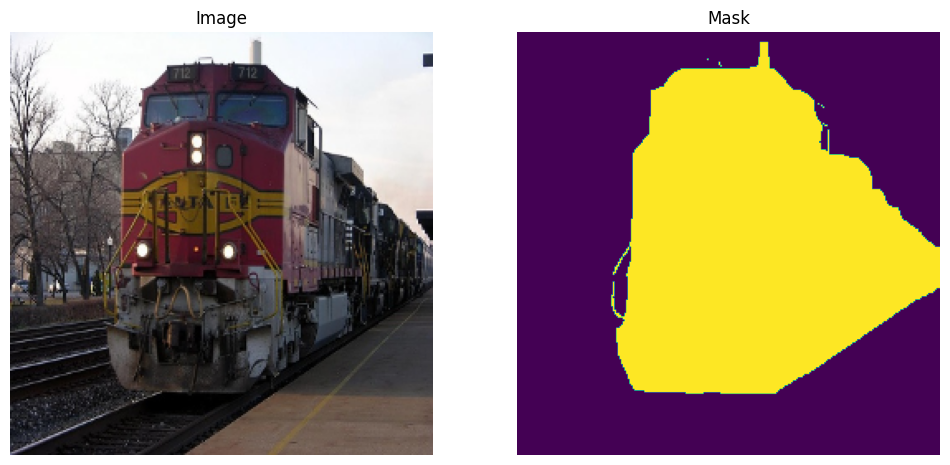

In [5]:
idx = random.randint(0, len(dataset)-1)
image, mask = dataset[idx]
print(np.unique(mask))
print(image.shape, mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="viridis")
ax[1].set_title("Mask")
ax[1].axis("off")

plt.show()